In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missing_process.missing_method as missing_method
from missing_process.block_rules import *

{'1': {'lower': 0.0, 'upper': 0.25, 'partial_missing': 0.5}}

In [96]:
def missing_by_range(X,multiple_block,missing_dim=1):
    """    
    Missing_quantile: value is larger than quantile will be missing
    Missing_dim: how many columns have missing data
    Partial_missing: if partially or completely missing (default=0, partial_missing rate = 0), 
                    if larger means left more data
    Missing_type: middle, outside, multiple
    """

    #N, D = X.shape
    Xnan = X.copy()

    # ---- Missing Dimention
    missing_dim = int(missing_dim * 1)
    
    ix_list = []
    for key in multiple_block.keys():
        info = multiple_block[key]
        combined_ix = generate_middle(info["lower"],info["upper"],info["partial_missing"], X, missing_dim)
        ix_list.append(combined_ix)
    combined_ix = np.logical_or.reduce(ix_list)
  
    Xnan[:, :missing_dim][combined_ix] = np.nan

    Xz = Xnan.copy()
    Xz[np.isnan(Xnan)] = 0

    return Xnan, Xz


def generate_middle(lower,upper,partial_missing,dataset,missing_dim):
    if lower == 0:
        lower_quantile = np.min(dataset[:, :missing_dim], axis=0)
    else:
        lower_quantile = np.quantile(dataset[:, :missing_dim],lower, axis=0)
    if upper == 1:
        upper_quantile = np.max(dataset[:, :missing_dim], axis=0)
    else:
        upper_quantile = np.quantile(dataset[:, :missing_dim],upper, axis=0)

    ix_larger_than = dataset[:, :missing_dim] >= lower_quantile
    ix_smaller_than = dataset[:, :missing_dim] <= upper_quantile
    combined_ix = np.equal(ix_larger_than, ix_smaller_than)
    combined_ix = random_missing(combined_ix,partial_missing)
    
    return combined_ix


def random_missing(array, fractions_to_change):
    result = array.copy()
    for col in range(result.shape[1]):
        col_array = result[:, col]
        n_to_change = int(np.sum(col_array) * fractions_to_change)
        ix_to_change = np.random.choice(np.flatnonzero(col_array), size=n_to_change, replace=False)
        col_array[ix_to_change] = False
    return result

In [98]:
# 设置随机种子以确保结果可重复
np.random.seed(42)
sample_size = 1000
original_data = np.random.normal(size=sample_size)
original_data = np.column_stack((original_data, original_data))

missing_rule = load_json_file("complete.json")


Xnan_Q1_complete, Xz = missing_by_range(original_data, missing_rule["Q1_complete"])

Xnan_Q2_complete, Xz = missing_by_range(original_data, missing_rule["Q2_complete"])


Xnan_Q2_Q3_complete, Xz = missing_by_range(original_data, missing_rule["Q2_Q3_complete"])

Xnan_Q1_Q4_complete, Xz = missing_by_range(original_data, missing_rule["Q1_Q4_complete"])


Xnan_Q1_Q3_complete, Xz = missing_by_range(original_data, missing_rule["Q1_Q3_complete"])


three_blocks = {"1": {"lower": 0.0, "upper": 0.1, "partial_missing": 0.0}, "2": {"lower": 0.3, "upper": 0.5, "partial_missing": 0.0}, "3": {"lower": 0.7, "upper": 0.9, "partial_missing": 0.0}}
three_block_rule,Xz = missing_by_range(original_data, three_blocks)

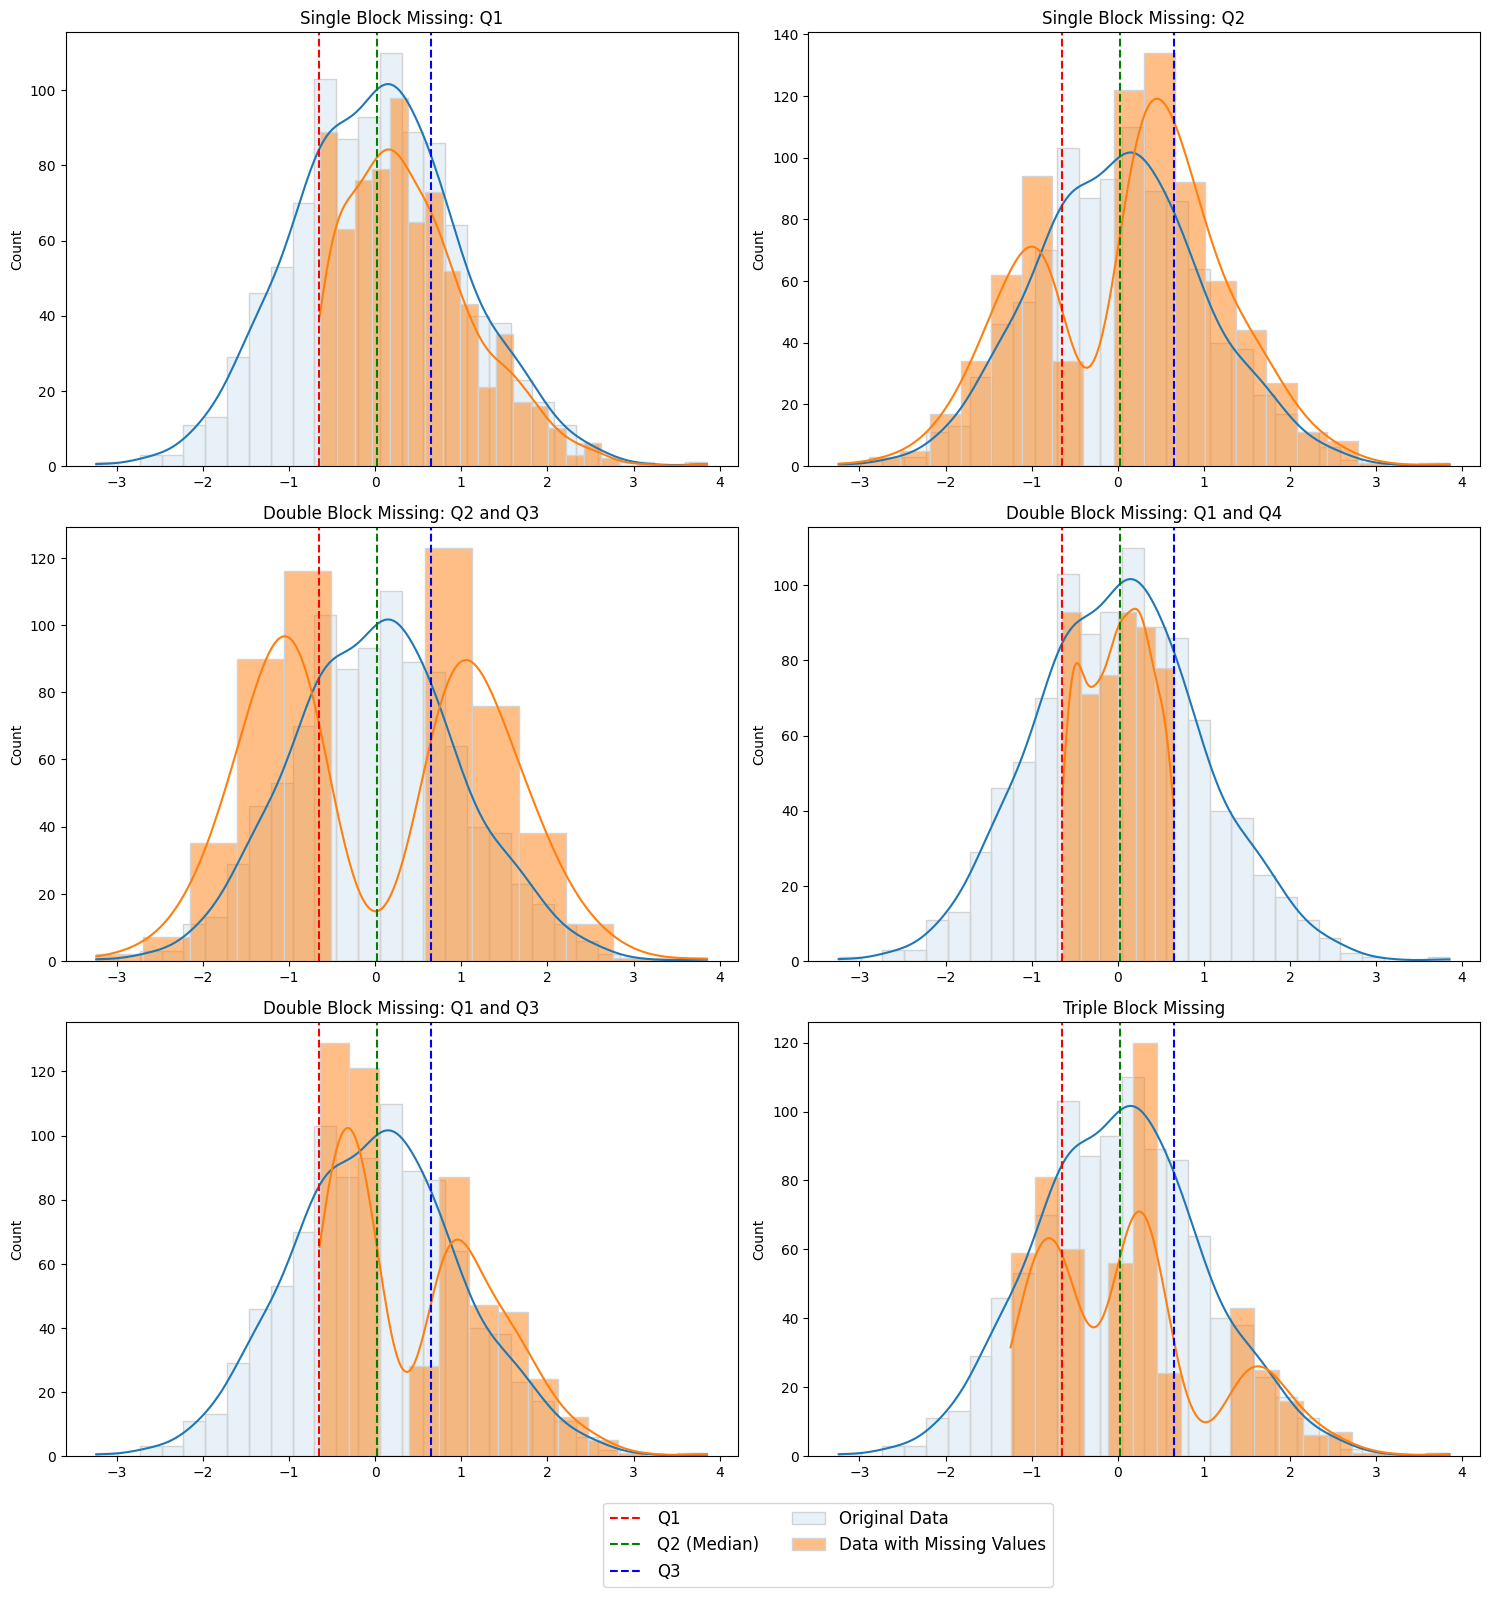

In [107]:
# 创建 3x2 子图
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4)

# 第一个子图
axe = axes[0, 0]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(Xnan_Q1_complete[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Single Block Missing: Q1')

# 第二个子图，以此类推...
axe = axes[0, 1]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(Xnan_Q2_complete[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Single Block Missing: Q2')



# 3..
axe = axes[1, 0]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(Xnan_Q2_Q3_complete[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Double Block Missing: Q2 and Q3')




# 4..
axe = axes[1, 1]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(Xnan_Q1_Q4_complete[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe,bins=6)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Double Block Missing: Q1 and Q4')


# 5..
axe = axes[2, 0]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(Xnan_Q1_Q3_complete[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Double Block Missing: Q1 and Q3')



# 6..
axe = axes[2, 1]
sns.histplot(original_data[:,0], kde=True, label='Original Data',alpha = 0.1, edgecolor='lightgray', ax=axe)
sns.histplot(three_block_rule[:,0], kde=True, label='Data with Missing Values',alpha = 0.5, edgecolor='lightgray', ax=axe)
axe.axvline(q1, color='red', linestyle='dashed', label='Q1')
axe.axvline(q2, color='green', linestyle='dashed', label='Q2 (Median)')
axe.axvline(q3, color='blue', linestyle='dashed', label='Q3')
axe.set_title('Triple Block Missing')

# 最后显示图形
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', fontsize='large', bbox_to_anchor=(0.4, 0), ncol=2)

plt.tight_layout()

plt.savefig("QuantileMissing.png")
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

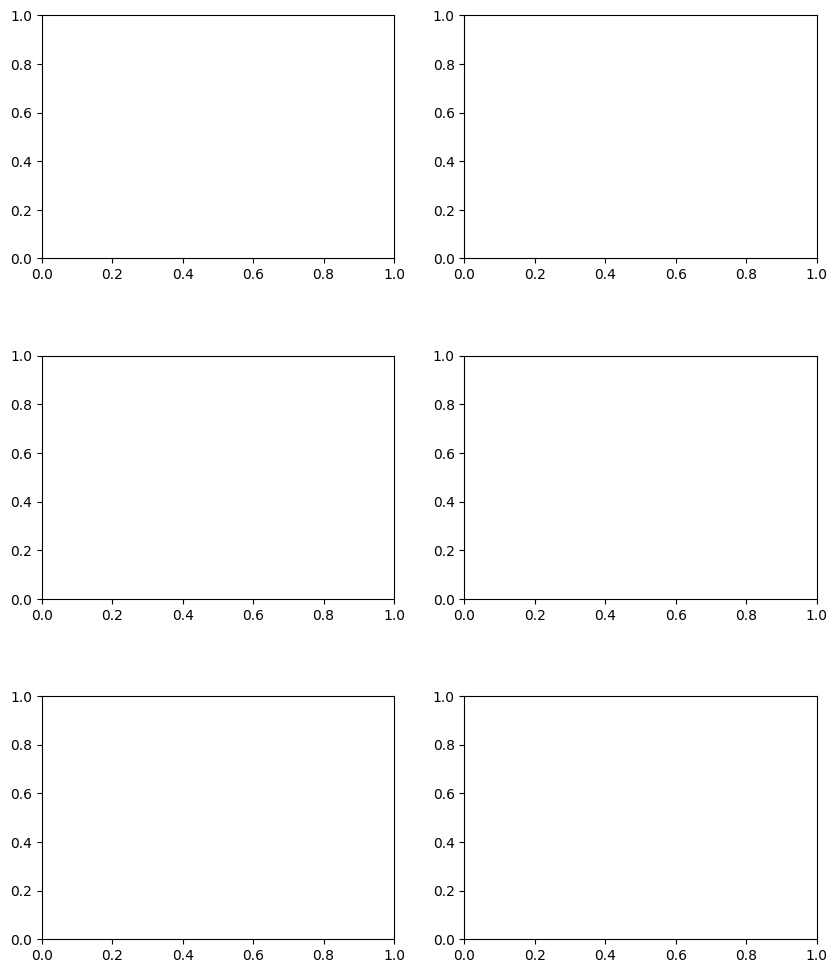

In [65]:
# Generate data
np.random.seed(0)
original_data = np.random.randn(100)
Xnan = original_data.copy()
missing_indices = np.random.choice(100, size=20, replace=False)
Xnan[missing_indices] = np.nan

# Create 3x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
fig.subplots_adjust(hspace=0.4)

# Create plots and add larger legend
for i in range(3):
    for j in range(2):
        ax = axes[i, j]
        sns.histplot(original_data[:, 0], kde=True, label='Original Data', alpha=0.5, edgecolor='lightgray', ax=ax)
        sns.histplot(Xnan[:, 0], kde=True, label='Data with Missing Values', alpha=0.5, edgecolor='lightgray', ax=ax)
        ax.set_title(f'Feature {i*2 + j + 1}')
        ax.legend(loc='upper right', fontsize='large')

# Add overall legend outside the subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', fontsize='large')

# Adjust layout and show plot
plt.tight_layout()
plt.show()